# UMAP Bench Performance Analysis (JS vs WASM features)

- RQ1: Compare runtime and memory performance across JS vs WASM feature variants
- RQ2: Evaluate scaling behavior across datasets (size/dimensionality when available)
- RQ3: Assess quality vs responsiveness trade-offs (quality, FPS, latency)

Dataset file: preprocessed.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import textwrap

try:
    import statsmodels.api as sm
except Exception:
    sm = None

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.max_colwidth", 200)

np.random.seed(42)
figs = {}


In [2]:
df = pd.read_csv("preprocessed.csv")
print("shape:", df.shape)
print("columns:", list(df.columns))
df.head()


shape: (420, 38)
columns: ['generated_at', 'runs_declared', 'result_run', 'result_wasm_features', 'result_success', 'result_duration_ms', 'result_label', 'stats_start_time', 'stats_duration_ms', 'stats_flaky', 'wasm_features_file', 'wasm_preload', 'machine_platform', 'machine_release', 'machine_arch', 'cpu_model', 'cpu_cores', 'total_mem_bytes', 'load_avg_1', 'load_avg_5', 'load_avg_15', 'hostname', 'git_commit', 'git_branch', 'git_status_dirty', 'ui_run_id', 'ui_timestamp', 'scope', 'dataset_name', 'dataset_size', 'dimensions', 'ui_wasm_features', 'wasm_mode', 'runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']


,generated_at,runs_declared,result_run,result_wasm_features,result_success,result_duration_ms,result_label,stats_start_time,stats_duration_ms,stats_flaky,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,ui_run_id,ui_timestamp,scope,dataset_name,dataset_size,dimensions,ui_wasm_features,wasm_mode,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-01-31T12:39:27.635Z,10,1,none,True,43526,PASS,2026-01-31T12:39:45.906Z,25293.620,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:03.865Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2326.9,-0.055005,0.986882,60.000000,8.600000
1,2026-01-31T12:39:27.635Z,10,1,none,True,43526,PASS,2026-01-31T12:39:45.906Z,25293.620,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:11.571Z,small,Small Random (80 points),80,10,none,js,3404.4,-4.720348,0.876677,48.204624,24.000000
2,2026-01-31T12:39:27.635Z,10,2,none,True,45124,PASS,2026-01-31T12:40:27.525Z,28781.219,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:50.544Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2297.1,2.982440,0.991627,60.000000,9.072727
3,2026-01-31T12:39:27.635Z,10,2,none,True,45124,PASS,2026-01-31T12:40:27.525Z,28781.219,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:56.801Z,small,Small Random (80 points),80,10,none,js,3291.8,14.746518,0.830674,48.000000,22.900000
4,2026-01-31T12:39:27.635Z,10,3,none,True,46734,PASS,2026-01-31T12:41:11.846Z,31195.437,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:41:36.835Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2334.0,1.219504,0.988568,59.994001,9.881818


In [28]:
required = {
    "Run": ["run", "run_id", "runid", "ui_run_id", "result_run"],
    "Runtime (ms)": ["runtime", "runtime_ms", "runtime(ms)", "time_ms", "time (ms)", "duration_ms", "duration (ms)", "runtime (ms)", "runtime_ms"],
    "Memory (MB)": ["memory", "memory_mb", "memory (mb)", "memory_delta_mb", "mem_mb"],
    "Quality (%)": ["quality", "quality_%", "quality (percent)", "quality_percent", "trustworthiness", "trustworthiness_%"],
    "FPS": ["fps", "fps_avg", "fps average"],
    "Latency (ms)": ["latency", "latency_ms", "latency (ms)", "responsiveness_ms", "responsiveness (ms)", "responsiveness"],
    "WASM Features": ["wasm features", "wasm_features", "wasm mode", "wasm_mode", "ui_wasm_features", "result_wasm_features"],
    "Dataset": ["dataset", "dataset_name", "datasetname"]
}

def _norm(s):
    return "".join(ch for ch in s.lower() if ch.isalnum() or ch == "%").strip()

cols_norm = {_norm(c): c for c in df.columns}
rename_map = {}
missing = []

for std_name, variants in required.items():
    candidates = [std_name] + variants
    found = None
    for cand in candidates:
        key = _norm(cand)
        if key in cols_norm:
            found = cols_norm[key]
            break
    if found is None:
        missing.append(std_name)
    else:
        if found != std_name:
            rename_map[found] = std_name

if missing:
    raise ValueError(f"Missing required columns: {missing}. Found columns: {list(df.columns)}")

if rename_map:
    df = df.rename(columns=rename_map)

print("renamed columns:", rename_map)


renamed columns: {}


In [29]:
df_raw = df.copy()

num_cols = ["Run", "Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

str_cols = ["WASM Features", "Dataset"]
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()

print("missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

df = df.dropna(subset=["Runtime (ms)", "Dataset"])


missing values per column:
dataset_size_extracted    420
runs_declared               0
generated_at                0
result_wasm_features        0
result_success              0
result_duration_ms          0
result_label                0
stats_start_time            0
stats_duration_ms           0
stats_flaky                 0
result_run                  0
wasm_features_file          0
wasm_preload                0
machine_release             0
machine_platform            0
cpu_model                   0
cpu_cores                   0
total_mem_bytes             0
machine_arch                0
load_avg_5                  0
load_avg_15                 0
hostname                    0
git_commit                  0
git_branch                  0
git_status_dirty            0
Run                         0
load_avg_1                  0
ui_timestamp                0
scope                       0
dataset_size                0
Dataset                     0
ui_wasm_features            0
WASM Features

In [30]:
flags = {}
flags["negative_runtime"] = (df["Runtime (ms)"] < 0)
flags["negative_memory"] = (df["Memory (MB)"] < 0)
flags["negative_latency"] = (df["Latency (ms)"] < 0)
flags["negative_fps"] = (df["FPS"] < 0)
flags["quality_out_of_range"] = ~df["Quality (%)"].between(0, 100, inclusive="both")

print("flagged row counts:")
for k, v in flags.items():
    print(k, int(v.sum()))


flagged row counts:
negative_runtime 0
negative_memory 35
negative_latency 0
negative_fps 0
quality_out_of_range 0


In [31]:
import re

def normalize_wasm_mode(s):
    if s is None:
        return "other"
    s = str(s).strip().lower()
    if s in ["js", "none", "baseline", "no", "false"]:
        return "js"
    tokens = [t for t in re.split(r"[^a-z]+", s) if t]
    known = {"dist", "tree", "matrix", "nn", "opt"}
    feats = [t for t in tokens if t in known]
    if not feats:
        return "other"
    if len(set(feats)) == 1:
        return feats[0]
    if len(set(feats)) > 1:
        return "all"
    return "other"

df["wasm_mode"] = df["WASM Features"].apply(normalize_wasm_mode)
df["is_wasm"] = df["wasm_mode"] != "js"
df["dataset_name"] = df["Dataset"].astype(str).str.strip()

df["run_id"] = df["dataset_name"].astype(str) + "|" + df["wasm_mode"].astype(str) + "|" + df["Run"].astype(str)


## Overview distributions

We summarize runtime, memory, quality, FPS, and latency overall and by dataset/wasm_mode groups to establish baseline distributions before deeper comparisons.


In [32]:
numeric_cols = ["Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
df[numeric_cols].describe()


,Runtime (ms),Memory (MB),Quality (%),FPS,Latency (ms)
count,420.000000,420.000000,420.000000,420.000000,420.000000
mean,3151.655238,12.487627,0.897144,47.372629,35.666322
std,1192.702974,11.107096,0.143303,16.910399,35.571111
min,590.200000,-10.351616,0.558903,0.000000,0.000000
25%,2334.825000,3.070176,0.857520,46.943669,18.620455
50%,3034.050000,12.561723,0.968620,50.219093,21.760000
75%,3943.425000,18.307228,0.994074,59.986233,30.233333
max,6979.800000,58.902415,0.997495,60.163724,138.627273


In [33]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

grouped = df.groupby(["dataset_name", "wasm_mode"], dropna=False)
summary = grouped.agg({
    "Runtime (ms)": ["count", "mean", "median", "std", q25, q75],
    "Memory (MB)": ["mean", "median", "std"],
    "Quality (%)": ["mean", "median", "std"],
    "FPS": ["mean", "median", "std"],
    "Latency (ms)": ["mean", "median", "std", q25, q75],
})
summary.columns = ["_".join(map(str, c)).strip() for c in summary.columns]
summary = summary.reset_index().sort_values(["dataset_name", "wasm_mode"])
summary


,dataset_name,wasm_mode,Runtime (ms)_count,Runtime (ms)_mean,Runtime (ms)_median,Runtime (ms)_std,Runtime (ms)_q25,Runtime (ms)_q75,Memory (MB)_mean,Memory (MB)_median,Memory (MB)_std,Quality (%)_mean,Quality (%)_median,Quality (%)_std,FPS_mean,FPS_median,FPS_std,Latency (ms)_mean,Latency (ms)_median,Latency (ms)_std,Latency (ms)_q25,Latency (ms)_q75
0,3D Dense Clusters (1K points),all,10,3428.73,3420.50,56.688761,3391.000,3455.775,9.635542,5.865060,7.821089,0.997068,0.997081,0.000141,37.129501,37.278651,1.196349,26.890000,26.830000,1.055166,26.533333,27.128333
1,3D Dense Clusters (1K points),dist,10,4575.63,4576.60,147.898870,4501.475,4626.750,12.224287,11.815961,5.672572,0.997199,0.997267,0.000246,49.837267,50.081112,0.808686,31.615333,31.400000,1.435370,30.421667,32.408333
2,3D Dense Clusters (1K points),js,10,4590.70,4570.95,102.437027,4513.600,4677.525,11.389048,11.506006,7.460398,0.997053,0.997112,0.000243,49.710977,50.068781,0.614639,31.142000,30.663333,1.371660,30.218333,31.993333
3,3D Dense Clusters (1K points),matrix,10,4963.42,4559.80,894.199672,4517.300,4680.600,10.954171,5.935215,9.798041,0.997136,0.997129,0.000163,48.888631,49.541948,1.851148,25.526667,27.713333,5.587691,26.340000,28.283333
4,3D Dense Clusters (1K points),nn,10,4629.49,4628.20,94.588623,4559.675,4695.600,14.264342,13.213735,6.974675,0.997191,0.997226,0.000167,48.830796,49.980012,2.622011,29.502667,29.466667,0.777144,28.840000,30.226667
5,3D Dense Clusters (1K points),opt,10,3479.17,3441.50,79.141660,3425.700,3508.950,1.784711,1.893861,5.620231,0.997071,0.997150,0.000159,36.458930,36.571260,2.258648,31.046000,30.793333,1.217062,30.413333,31.610000
6,3D Dense Clusters (1K points),tree,10,4612.51,4612.00,94.718641,4551.800,4663.800,14.379409,17.993635,6.133092,0.997193,0.997272,0.000155,49.612247,49.992501,1.076211,31.642000,31.873333,1.189140,31.395000,32.098333
7,"Iris Dataset (150 points, 4D)",all,10,652.77,646.10,39.009402,624.725,673.950,12.874866,13.059022,0.745093,0.985771,0.986096,0.001259,0.000000,0.000000,0.000000,9.894545,10.059091,0.797887,9.281818,10.293182
8,"Iris Dataset (150 points, 4D)",dist,10,2309.41,2304.30,17.075288,2298.675,2317.450,1.436835,1.776195,0.953885,0.987402,0.987381,0.001472,59.995418,59.997000,0.008389,8.324545,8.154545,0.520208,7.981818,8.490909
9,"Iris Dataset (150 points, 4D)",js,10,2316.60,2311.05,15.589669,2307.100,2324.025,1.317460,1.295218,1.220433,0.988606,0.988278,0.001453,59.993805,59.994001,0.006763,9.193636,9.077273,0.402929,9.015909,9.422727


In [34]:
baseline = df[df["wasm_mode"] == "js"].groupby("dataset_name").agg({
    "Runtime (ms)": "median",
    "Memory (MB)": "median",
    "Quality (%)": "median",
    "FPS": "median",
    "Latency (ms)": "median"
}).rename(columns={
    "Runtime (ms)": "baseline_runtime_median",
    "Memory (MB)": "baseline_memory_median",
    "Quality (%)": "baseline_quality_median",
    "FPS": "baseline_fps_median",
    "Latency (ms)": "baseline_latency_median"
})

df_cmp = df.merge(baseline, on="dataset_name", how="left")

df_cmp["runtime_speedup"] = df_cmp["baseline_runtime_median"] / df_cmp["Runtime (ms)"]
df_cmp["runtime_delta_ms"] = df_cmp["Runtime (ms)"] - df_cmp["baseline_runtime_median"]
df_cmp["memory_delta_mb"] = df_cmp["Memory (MB)"] - df_cmp["baseline_memory_median"]
df_cmp["quality_delta"] = df_cmp["Quality (%)"] - df_cmp["baseline_quality_median"]
df_cmp["fps_delta"] = df_cmp["FPS"] - df_cmp["baseline_fps_median"]
df_cmp["latency_delta_ms"] = df_cmp["Latency (ms)"] - df_cmp["baseline_latency_median"]

delta_summary = df_cmp.groupby(["dataset_name", "wasm_mode"], dropna=False).agg({
    "runtime_speedup": ["median", "mean"],
    "runtime_delta_ms": ["median", "mean"],
    "memory_delta_mb": ["median", "mean"],
    "quality_delta": ["median", "mean"],
    "fps_delta": ["median", "mean"],
    "latency_delta_ms": ["median", "mean"]
})
delta_summary.columns = ["_".join(map(str, c)).strip() for c in delta_summary.columns]
delta_summary.reset_index().sort_values(["dataset_name", "wasm_mode"])


,dataset_name,wasm_mode,runtime_speedup_median,runtime_speedup_mean,runtime_delta_ms_median,runtime_delta_ms_mean,memory_delta_mb_median,memory_delta_mb_mean,quality_delta_median,quality_delta_mean,fps_delta_median,fps_delta_mean,latency_delta_ms_median,latency_delta_ms_mean
0,3D Dense Clusters (1K points),all,1.336376,1.333456,-1.150450e+03,-1142.22,-5.640946e+00,-1.870464,-3.111734e-05,-0.000045,-1.279013e+01,-12.939281,-3.833333e+00,-3.773333
1,3D Dense Clusters (1K points),dist,0.998767,0.999903,5.650000e+00,4.68,3.099546e-01,0.718280,1.541858e-04,0.000087,1.233095e-02,-0.231514,7.366667e-01,0.952000
2,3D Dense Clusters (1K points),js,1.000004,0.996142,4.547474e-13,19.75,8.881784e-16,-0.116958,-5.551115e-17,-0.000059,0.000000e+00,-0.357804,-1.776357e-15,0.478667
3,3D Dense Clusters (1K points),matrix,1.002446,0.942633,-1.115000e+01,392.47,-5.570791e+00,-0.551835,1.617422e-05,0.000023,-5.268335e-01,-1.180150,-2.950000e+00,-5.136667
4,3D Dense Clusters (1K points),nn,0.987700,0.987726,5.725000e+01,58.54,1.707728e+00,2.758336,1.131771e-04,0.000079,-8.876885e-02,-1.237986,-1.196667e+00,-1.160667
5,3D Dense Clusters (1K points),opt,1.328185,1.314404,-1.129450e+03,-1091.78,-9.612145e+00,-9.721295,3.735779e-05,-0.000041,-1.349752e+01,-13.609852,1.300000e-01,0.382667
6,3D Dense Clusters (1K points),tree,0.991113,0.991367,4.105000e+01,41.56,6.487628e+00,2.873403,1.594074e-04,0.000081,-7.628009e-02,-0.456535,1.210000e+00,0.978667
7,"Iris Dataset (150 points, 4D)",all,3.580085,3.551287,-1.664950e+03,-1658.28,1.176380e+01,11.579649,-2.182087e-03,-0.002507,-5.999400e+01,-59.994001,9.818182e-01,0.817273
8,"Iris Dataset (150 points, 4D)",dist,1.002929,1.000759,-6.750000e+00,-1.64,4.809771e-01,0.141617,-8.977609e-04,-0.000876,2.999700e-03,0.001417,-9.227273e-01,-0.752727
9,"Iris Dataset (150 points, 4D)",js,1.000000,0.997645,2.273737e-13,5.55,0.000000e+00,0.022243,-5.551115e-17,0.000328,0.000000e+00,-0.000196,0.000000e+00,0.116364


/tmp/ipykernel_63435/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
/tmp/ipykernel_63435/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
/tmp/ipykernel_63435/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
/tmp/ipykernel_63435/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for th

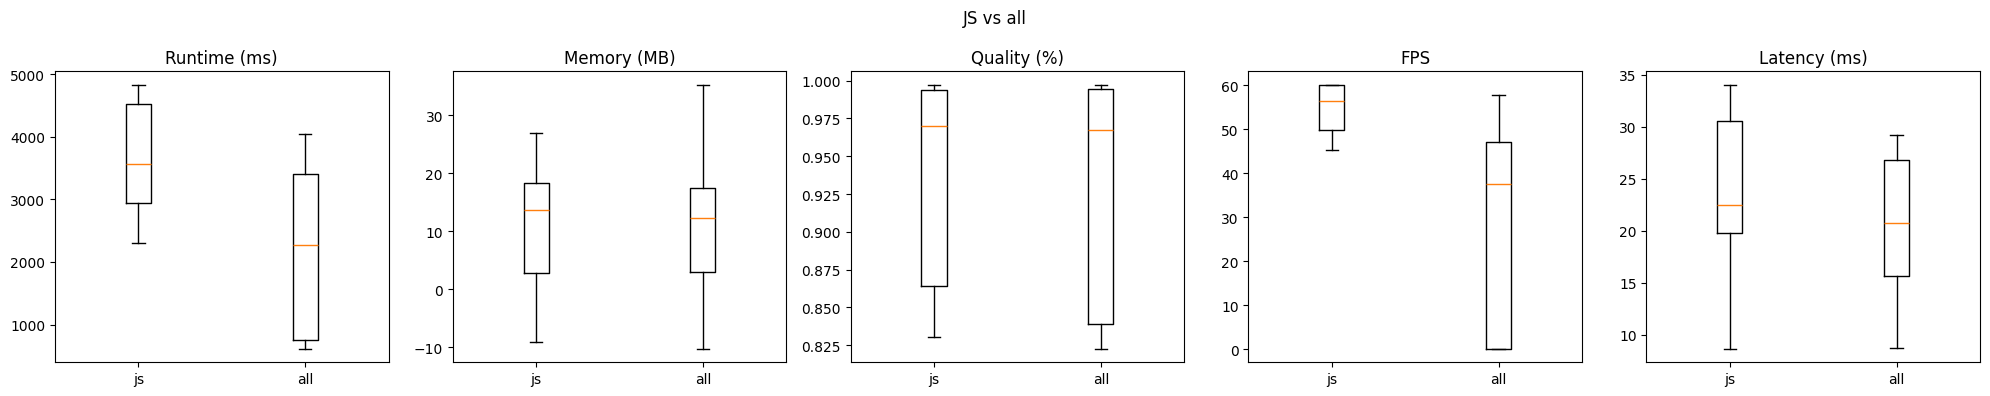

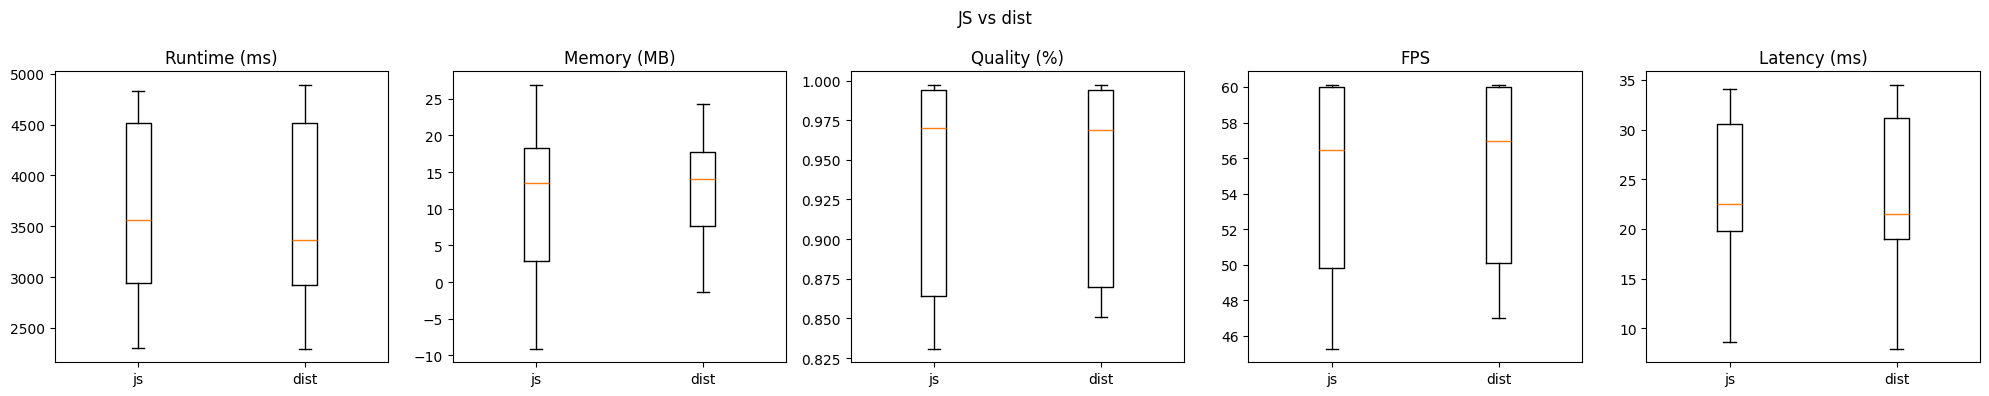

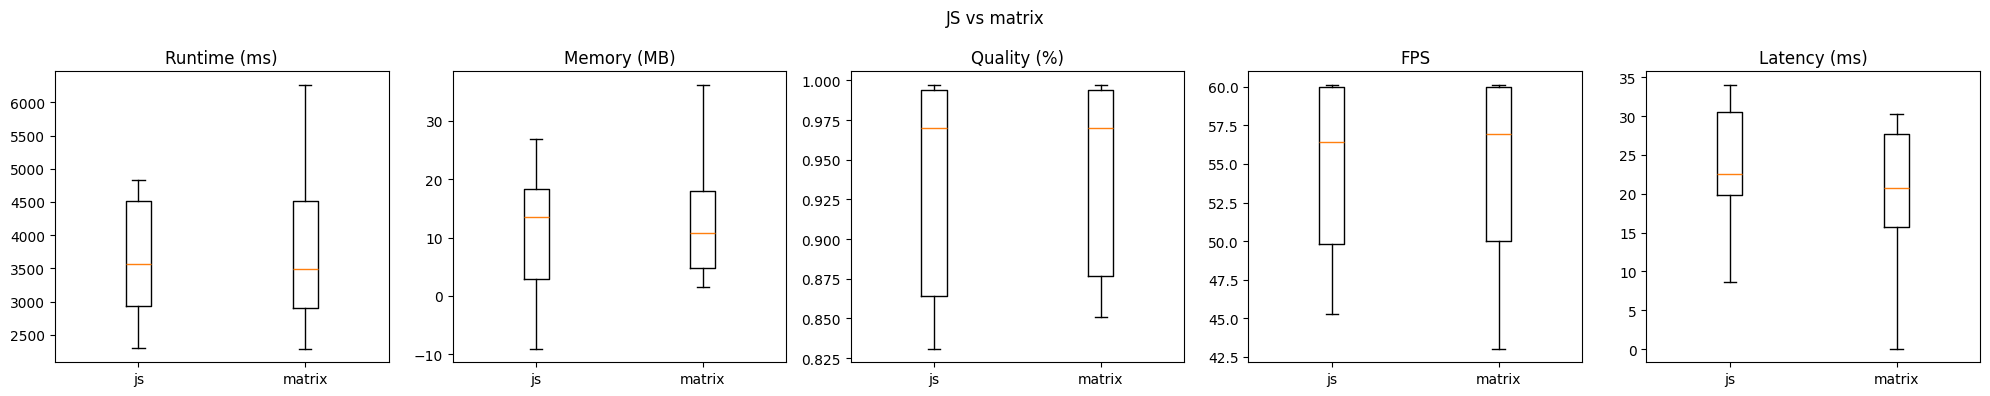

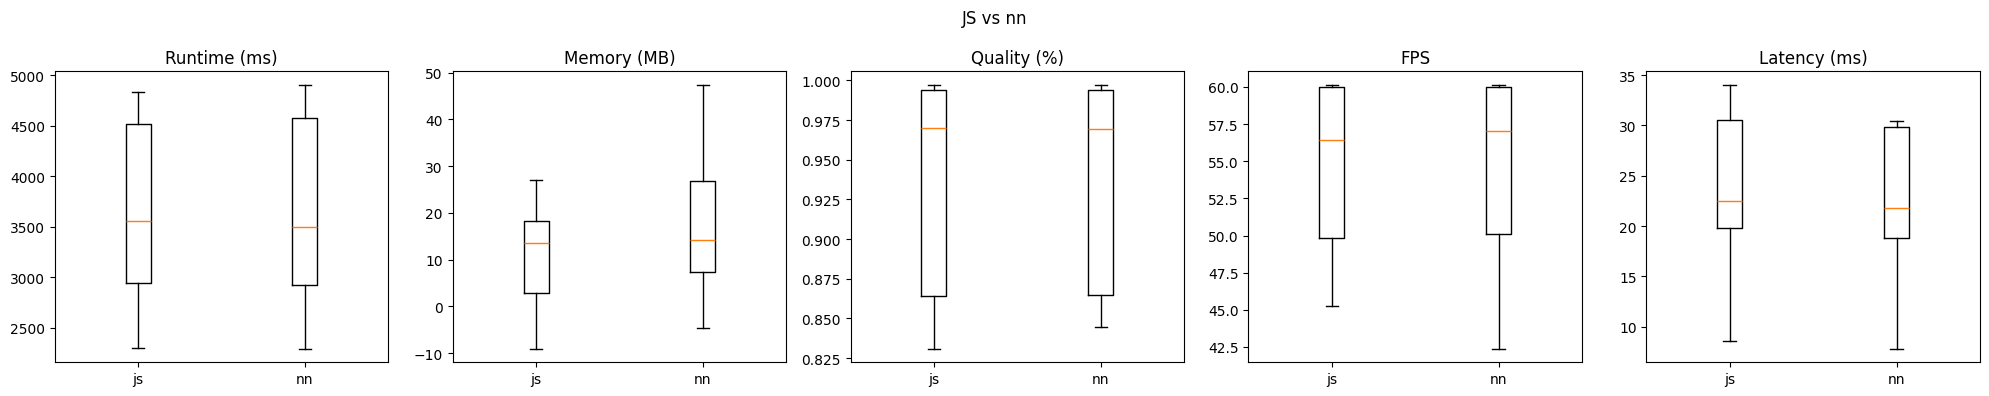

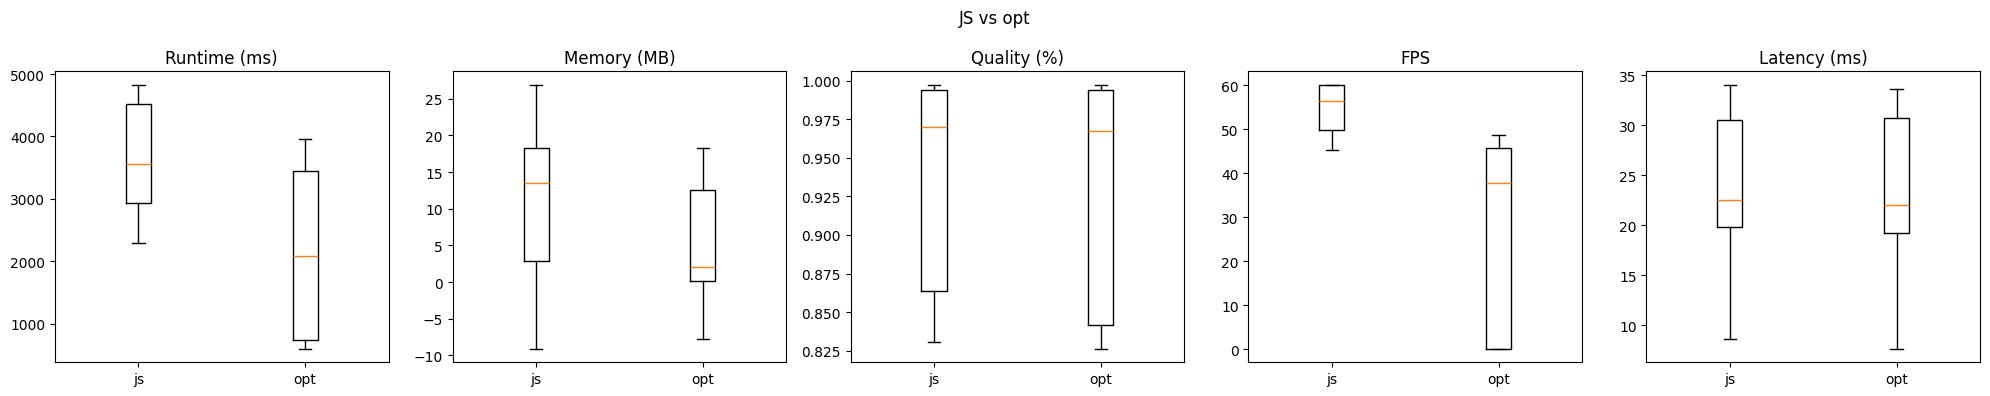

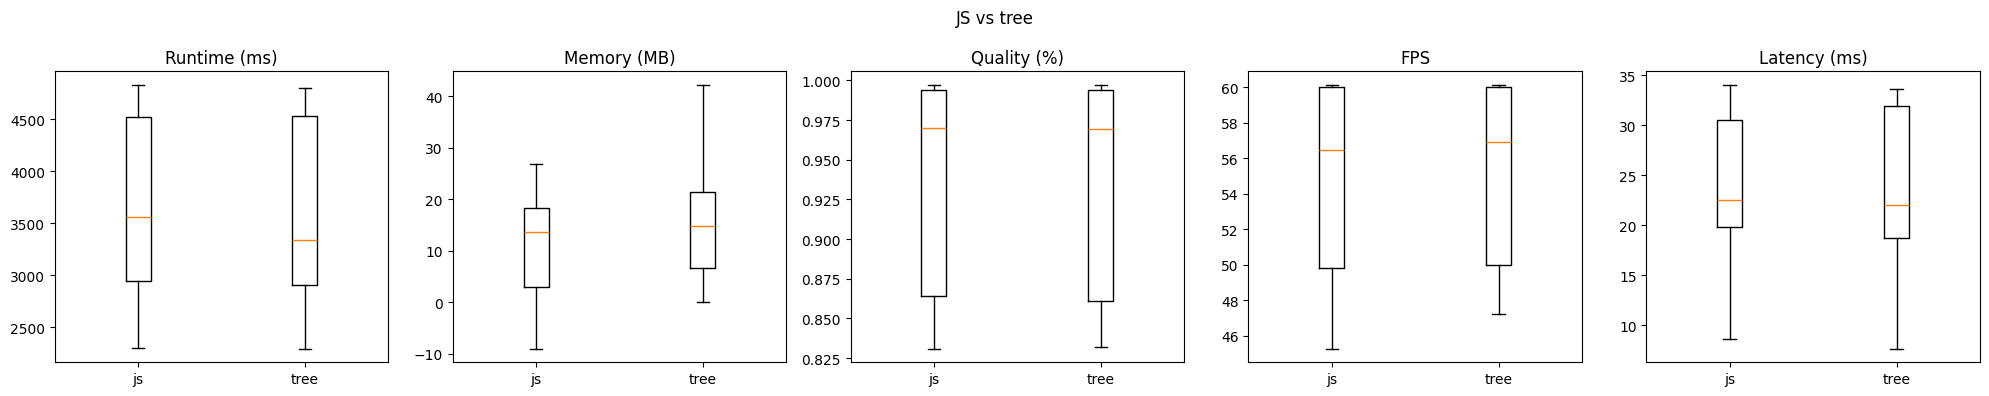

In [35]:
# JS vs each WASM feature (runtime/memory/quality/fps/latency)
metrics = ["Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
modes = [m for m in sorted(df["wasm_mode"].unique()) if m != "js"]
for m in modes:
    subset = df[df["wasm_mode"].isin(["js", m])]
    fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4), sharey=False)
    fig.suptitle(f"JS vs {m}")
    for ax, metric in zip(axes, metrics):
        data_js = subset[subset["wasm_mode"] == "js"][metric].dropna()
        data_m = subset[subset["wasm_mode"] == m][metric].dropna()
        ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
        ax.set_title(metric)
    plt.tight_layout()
    figs[f"js_vs_{m}"] = fig


/tmp/ipykernel_63435/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
/tmp/ipykernel_63435/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
/tmp/ipykernel_63435/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
/tmp/ipykernel_63435/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Mat

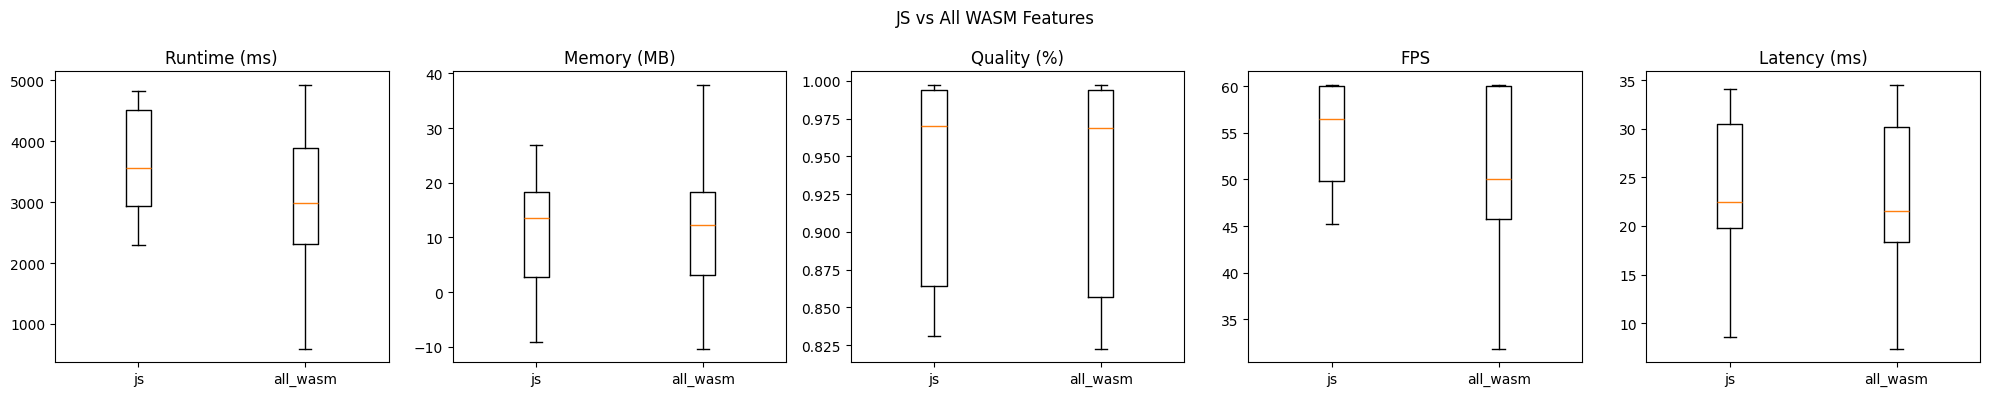

In [11]:
# JS vs all WASM (combined)
metrics = ["Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
subset = df.copy()
subset["wasm_group"] = subset["wasm_mode"].apply(lambda x: "js" if x == "js" else "all_wasm")
fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4), sharey=False)
fig.suptitle("JS vs All WASM Features")
for ax, metric in zip(axes, metrics):
    data_js = subset[subset["wasm_group"] == "js"][metric].dropna()
    data_w = subset[subset["wasm_group"] == "all_wasm"][metric].dropna()
    ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
    ax.set_title(metric)
plt.tight_layout()
figs["js_vs_all_wasm"] = fig


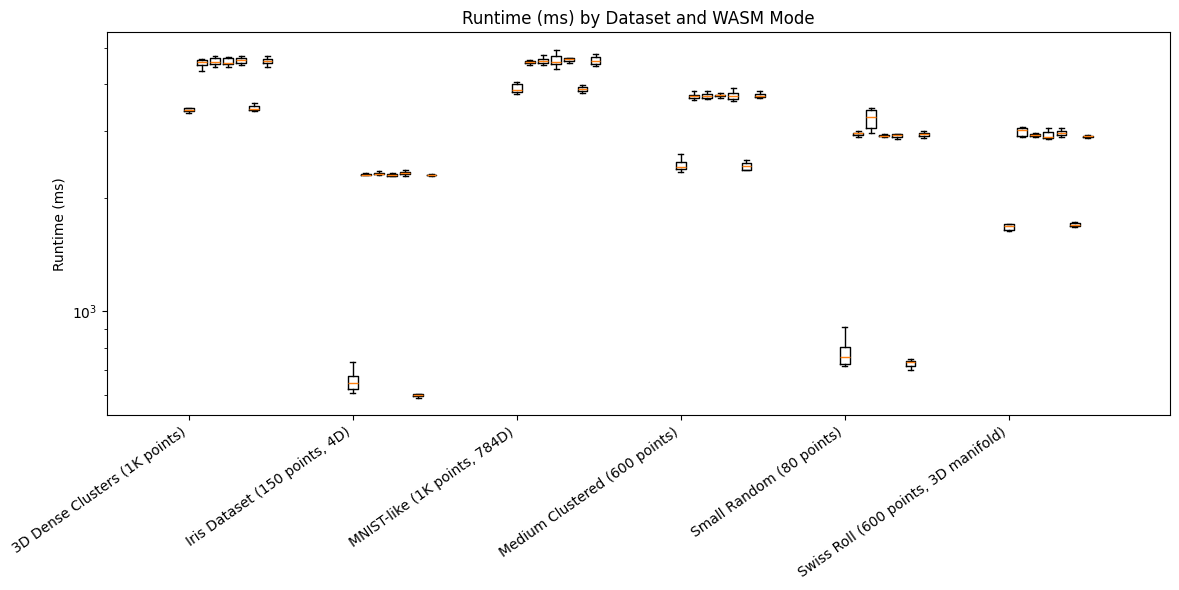

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))

ax.set_title("Runtime (ms) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Runtime (ms)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)

ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Runtime (ms)")
ax.set_yscale("log")
plt.tight_layout()
figs["runtime_boxplot"] = fig


Note: browser heap deltas are approximate and can be noisy across runs.


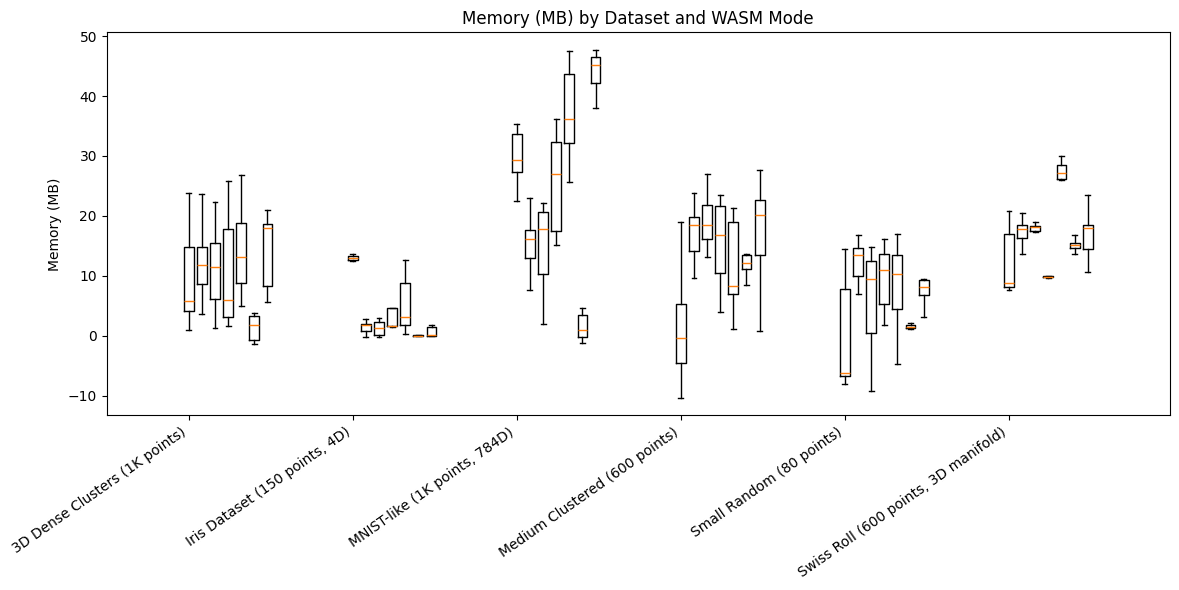

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("Memory (MB) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Memory (MB)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Memory (MB)")
plt.tight_layout()
figs["memory_boxplot"] = fig


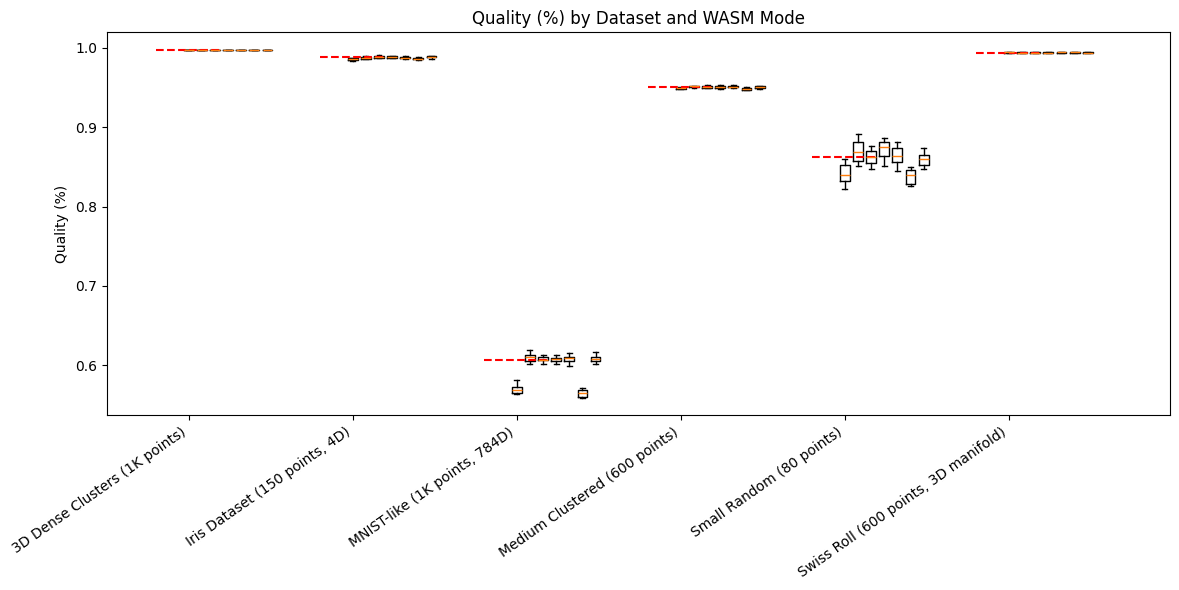

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("Quality (%) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Quality (%)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
    if (subset["wasm_mode"] == "js").any():
        js_median = subset[subset["wasm_mode"] == "js"]["Quality (%)"].median()
        ax.hlines(js_median, i - 0.2, i + 0.2, colors="red", linestyles="dashed")
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Quality (%)")
plt.tight_layout()
figs["quality_boxplot"] = fig


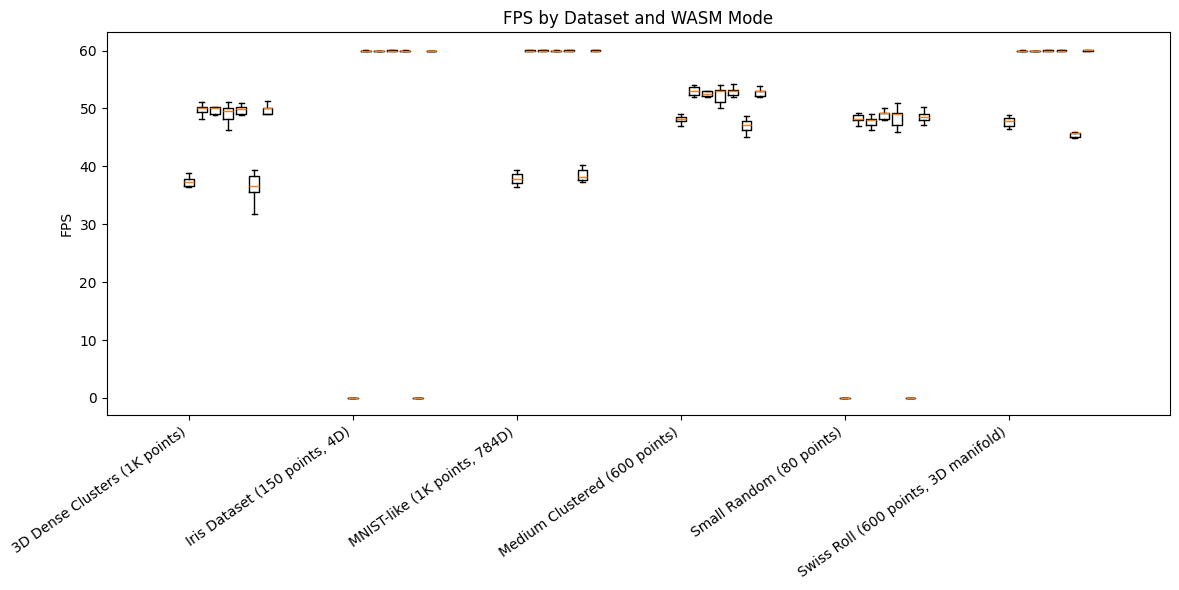

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("FPS by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["FPS"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("FPS")
plt.tight_layout()
figs["fps_boxplot"] = fig


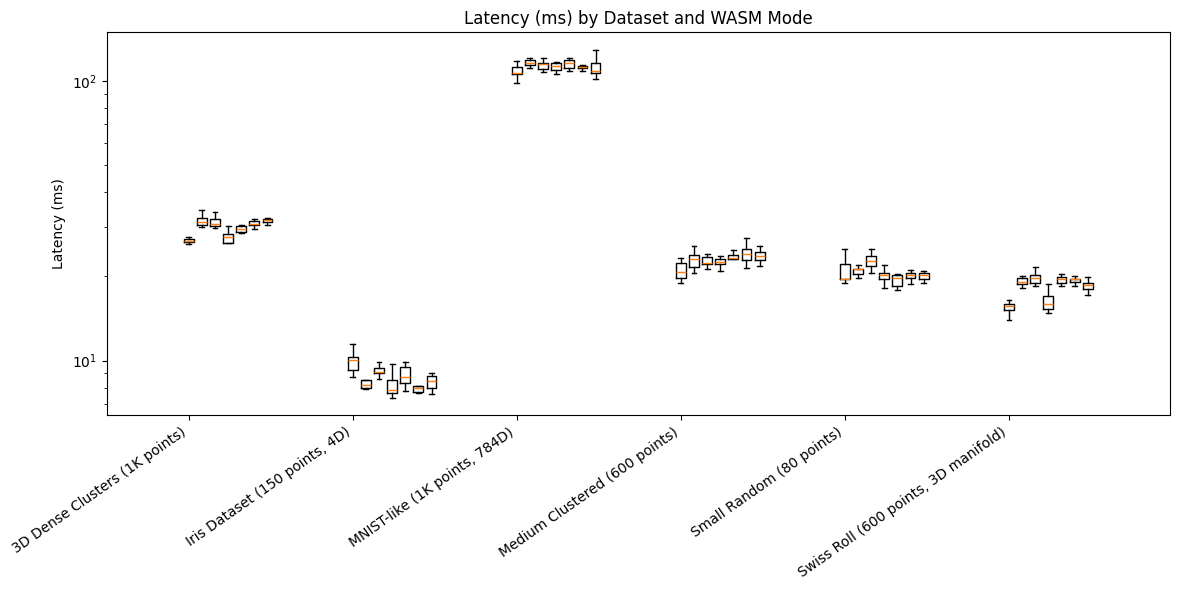

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("Latency (ms) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Latency (ms)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
ax.set_yscale("log")
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Latency (ms)")
plt.tight_layout()
figs["latency_boxplot"] = fig


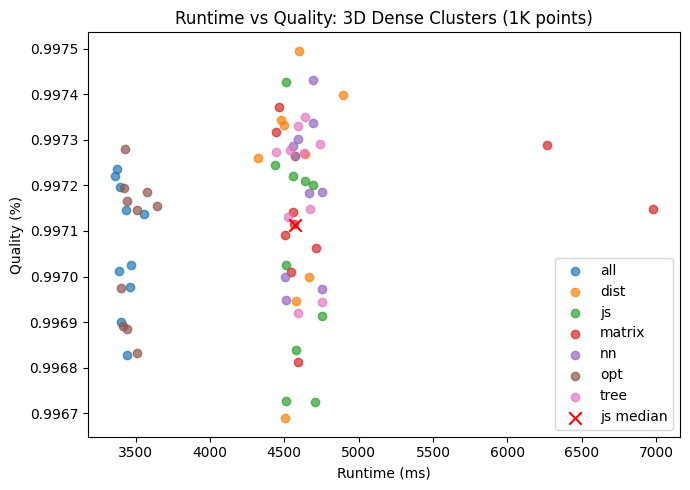

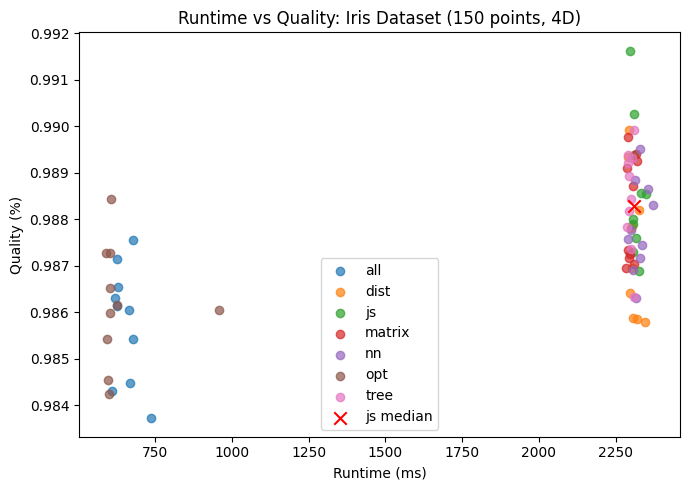

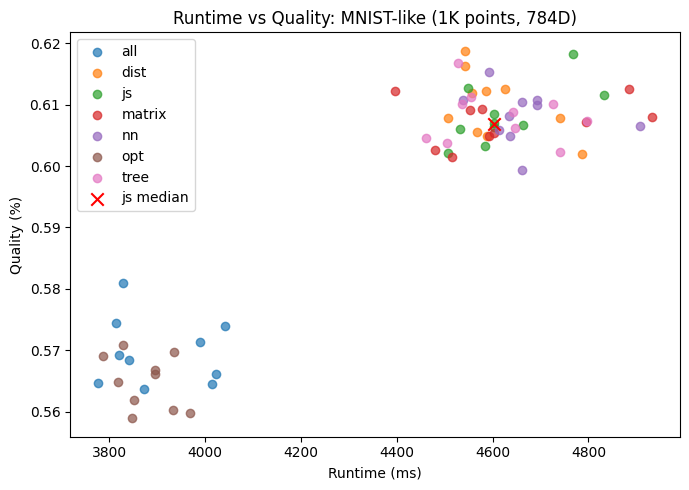

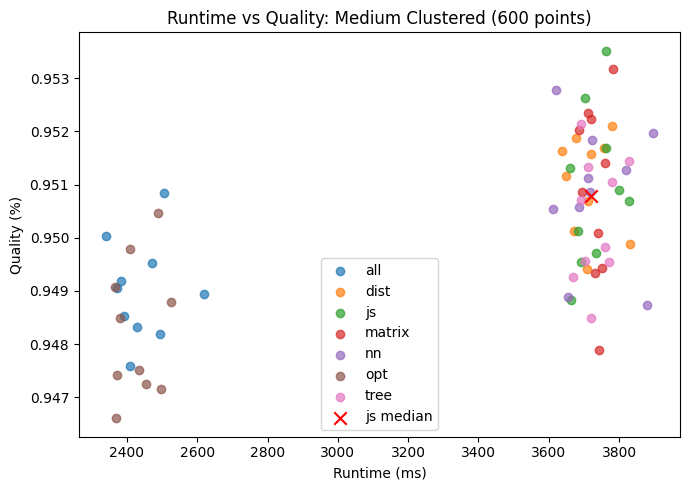

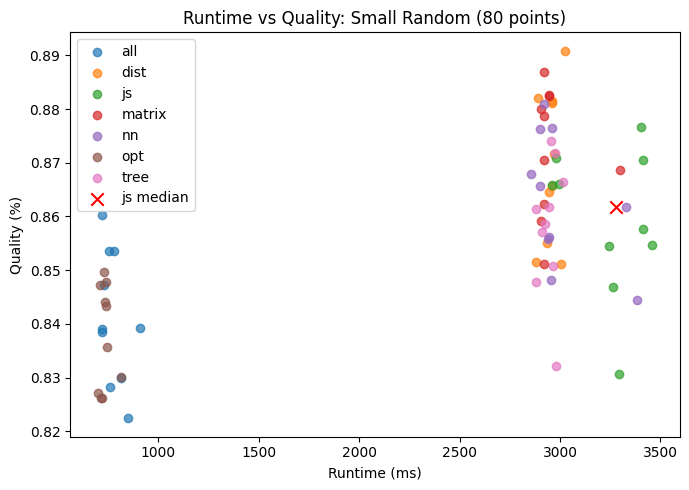

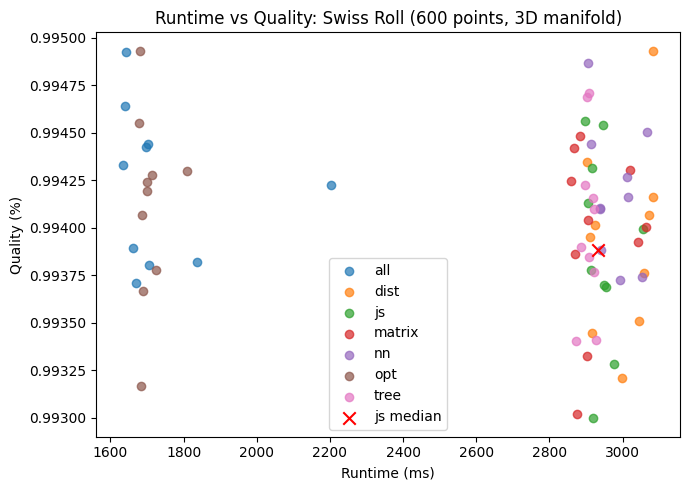

In [40]:
figs["runtime_quality"] = []
for d in sorted(df["dataset_name"].unique()):
    subset = df[df["dataset_name"] == d]
    fig, ax = plt.subplots(figsize=(7, 5))
    for m, s in subset.groupby("wasm_mode"):
        ax.scatter(s["Runtime (ms)"], s["Quality (%)"], label=m, alpha=0.7)
    if (subset["wasm_mode"] == "js").any():
        js = subset[subset["wasm_mode"] == "js"]
        ax.scatter(js["Runtime (ms)"].median(), js["Quality (%)"].median(), color="red", s=80, marker="x", label="js median")
    ax.set_title(f"Runtime vs Quality: {d}")
    ax.set_xlabel("Runtime (ms)")
    ax.set_ylabel("Quality (%)")
    ax.legend()
    plt.tight_layout()
    figs["runtime_quality"].append((d, fig))


Responsiveness proxy: FPS and latency capture UI smoothness and reaction time.


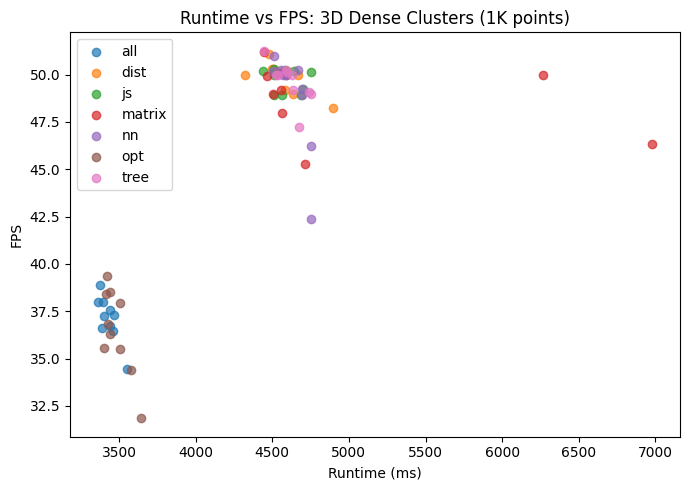

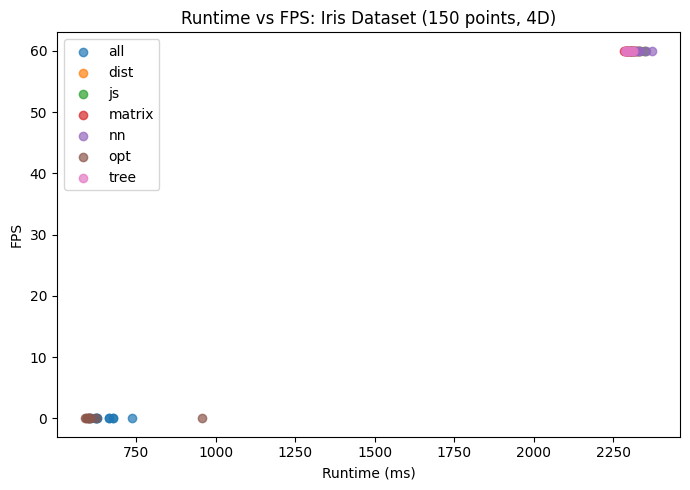

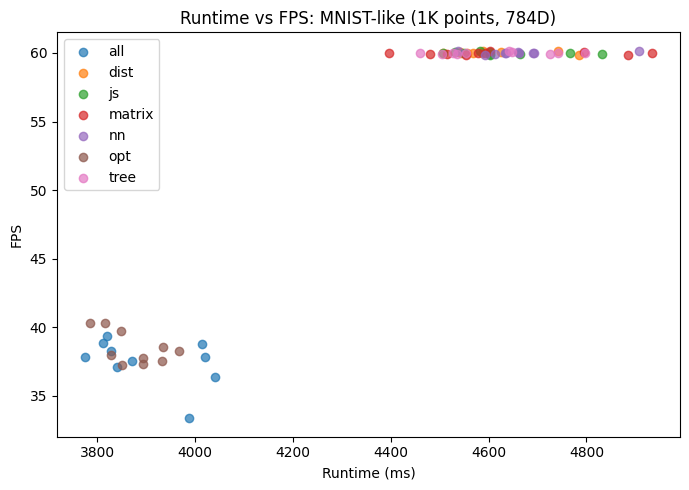

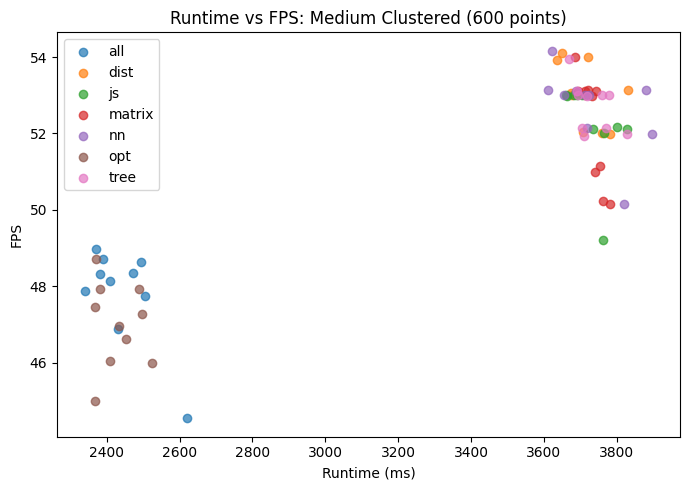

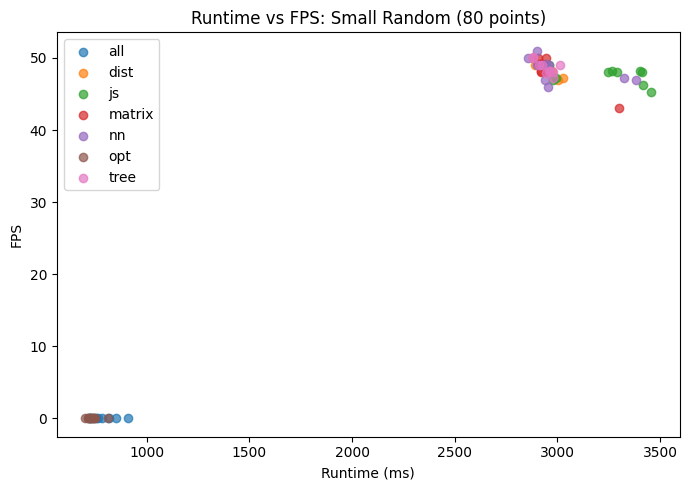

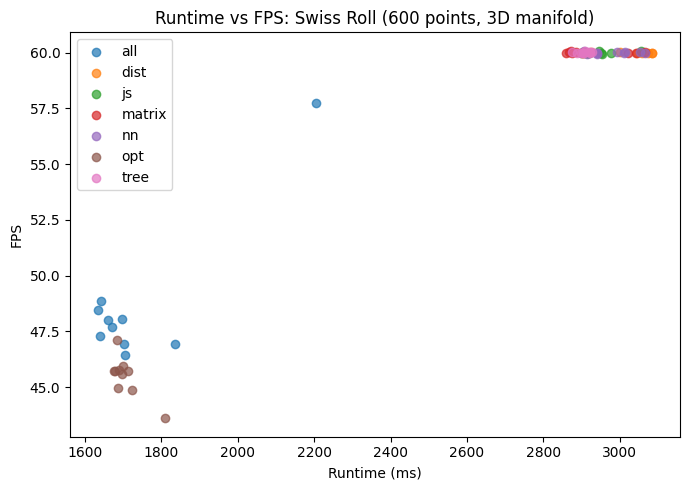

In [41]:
figs["runtime_fps"] = []
for d in sorted(df["dataset_name"].unique()):
    subset = df[df["dataset_name"] == d]
    fig, ax = plt.subplots(figsize=(7, 5))
    for m, s in subset.groupby("wasm_mode"):
        ax.scatter(s["Runtime (ms)"], s["FPS"], label=m, alpha=0.7)
    ax.set_title(f"Runtime vs FPS: {d}")
    ax.set_xlabel("Runtime (ms)")
    ax.set_ylabel("FPS")
    ax.legend()
    plt.tight_layout()
    figs["runtime_fps"].append((d, fig))


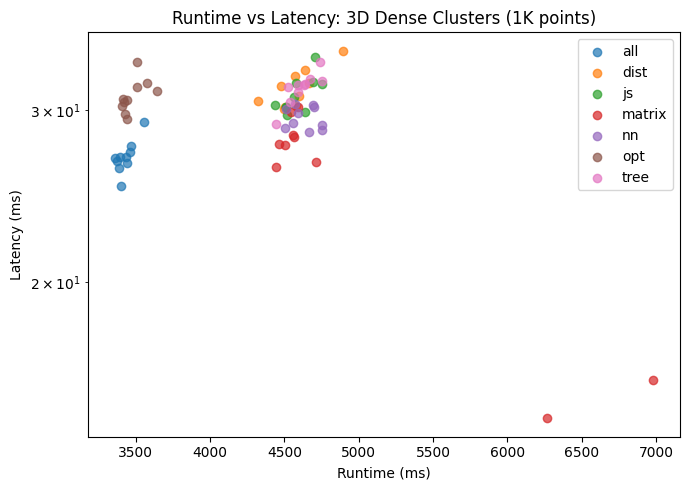

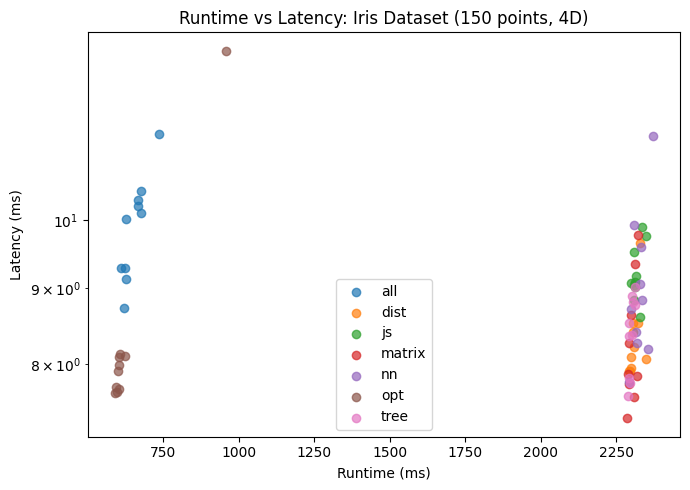

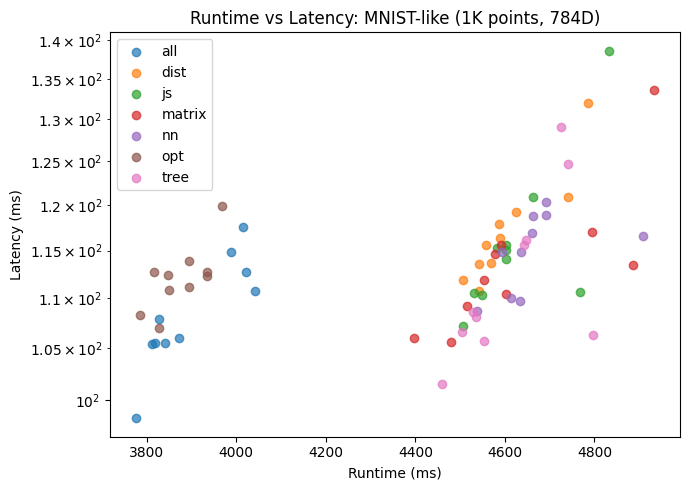

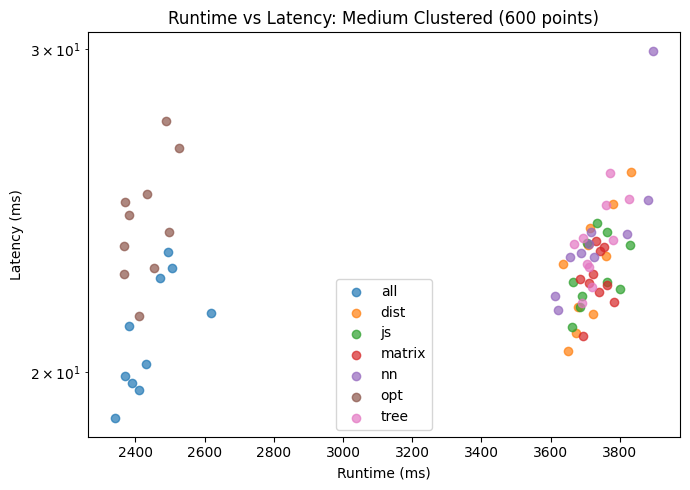

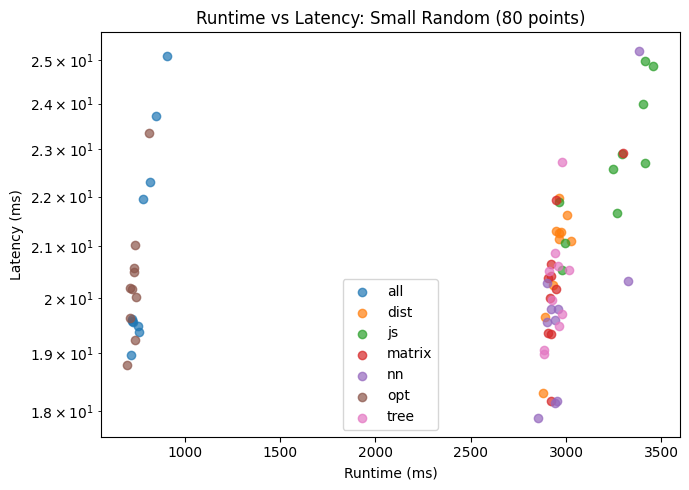

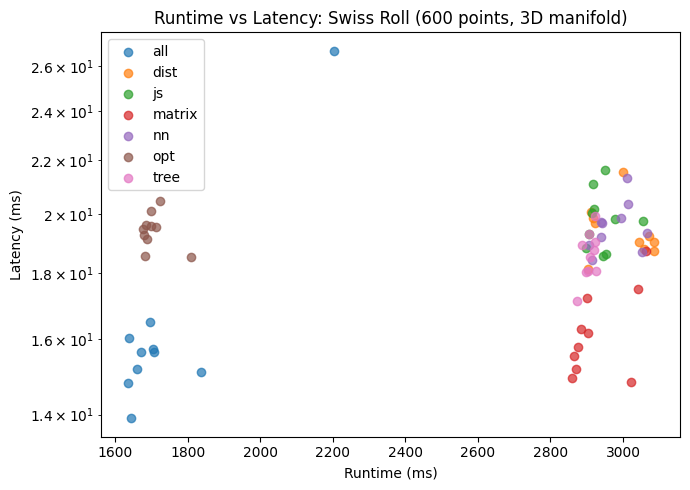

In [42]:
figs["runtime_latency"] = []
for d in sorted(df["dataset_name"].unique()):
    subset = df[df["dataset_name"] == d]
    fig, ax = plt.subplots(figsize=(7, 5))
    for m, s in subset.groupby("wasm_mode"):
        ax.scatter(s["Runtime (ms)"], s["Latency (ms)"], label=m, alpha=0.7)
    ax.set_title(f"Runtime vs Latency: {d}")
    ax.set_xlabel("Runtime (ms)")
    ax.set_ylabel("Latency (ms)")
    ax.set_yscale("log")
    ax.legend()
    plt.tight_layout()
    figs["runtime_latency"].append((d, fig))


In [43]:
def minmax_norm(series, maximize=True):
    x = series.astype(float)
    if x.max() == x.min():
        return pd.Series(0.0, index=x.index)
    if maximize:
        return (x - x.min()) / (x.max() - x.min())
    return (x.max() - x) / (x.max() - x.min())

pareto_results = []
for d, subset in df.groupby("dataset_name"):
    s = subset.copy()
    s["runtime_norm"] = minmax_norm(s["Runtime (ms)"], maximize=False)
    s["memory_norm"] = minmax_norm(s["Memory (MB)"], maximize=False)
    s["quality_norm"] = minmax_norm(s["Quality (%)"], maximize=True)
    s["fps_norm"] = minmax_norm(s["FPS"], maximize=True)
    s["latency_norm"] = minmax_norm(s["Latency (ms)"], maximize=False)
    s["composite_score"] = s[["runtime_norm", "memory_norm", "quality_norm", "fps_norm", "latency_norm"]].mean(axis=1)

    s = s.sort_values(["Runtime (ms)", "Quality (%)"])
    pareto = []
    best_quality = -np.inf
    for _, row in s.iterrows():
        if row["Quality (%)"] > best_quality:
            pareto.append(True)
            best_quality = row["Quality (%)"]
        else:
            pareto.append(False)
    s["pareto_runtime_quality"] = pareto

    top = s.sort_values("composite_score", ascending=False).head(5)
    top = top[["dataset_name", "wasm_mode", "Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)", "composite_score", "pareto_runtime_quality"]]
    pareto_results.append(top)

pareto_table = pd.concat(pareto_results, ignore_index=True)
pareto_table


,dataset_name,wasm_mode,Runtime (ms),Memory (MB),Quality (%),FPS,Latency (ms),composite_score,pareto_runtime_quality
0,3D Dense Clusters (1K points),matrix,4445.0,3.037091,0.997317,51.171029,26.266667,0.715157,True
1,3D Dense Clusters (1K points),js,4514.5,5.616053,0.997427,48.941270,29.673333,0.666722,True
2,3D Dense Clusters (1K points),js,4439.0,2.330914,0.997246,50.216621,30.380000,0.651038,False
3,3D Dense Clusters (1K points),nn,4556.7,7.539390,0.997286,50.256208,29.106667,0.637522,False
4,3D Dense Clusters (1K points),dist,4477.9,7.574071,0.997343,51.085568,31.793333,0.637466,False
5,"Iris Dataset (150 points, 4D)",matrix,2295.2,1.649886,0.987178,60.027554,0.000000,0.671734,False
6,"Iris Dataset (150 points, 4D)",tree,2292.0,-0.019635,0.989387,60.021647,7.827273,0.629160,False
7,"Iris Dataset (150 points, 4D)",js,2297.1,2.982440,0.991627,60.000000,9.072727,0.627003,True
8,"Iris Dataset (150 points, 4D)",matrix,2289.8,1.607921,0.989768,60.000000,7.754545,0.618936,True
9,"Iris Dataset (150 points, 4D)",dist,2291.4,0.695350,0.989332,59.980334,7.909091,0.617154,False


In [44]:
def bootstrap_ci_median(x, n=2000, ci=0.95, seed=42):
    rng = np.random.default_rng(seed)
    x = x.dropna().to_numpy()
    if len(x) == 0:
        return (np.nan, np.nan)
    meds = []
    for _ in range(n):
        sample = rng.choice(x, size=len(x), replace=True)
        meds.append(np.median(sample))
    low = np.quantile(meds, (1 - ci) / 2)
    high = np.quantile(meds, 1 - (1 - ci) / 2)
    return (low, high, meds)

def bootstrap_speedup(mode_x, base_x, n=2000, seed=42):
    rng = np.random.default_rng(seed)
    mode_x = mode_x.dropna().to_numpy()
    base_x = base_x.dropna().to_numpy()
    if len(mode_x) == 0 or len(base_x) == 0:
        return (np.nan, np.nan, np.nan)
    vals = []
    for _ in range(n):
        m_sample = rng.choice(mode_x, size=len(mode_x), replace=True)
        b_sample = rng.choice(base_x, size=len(base_x), replace=True)
        m_med = np.median(m_sample)
        b_med = np.median(b_sample)
        vals.append(b_med / m_med if m_med != 0 else np.nan)
    low = np.nanquantile(vals, 0.025)
    high = np.nanquantile(vals, 0.975)
    point = np.nanmedian(vals)
    return (low, high, point)

ci_rows = []
for (d, m), subset in df.groupby(["dataset_name", "wasm_mode"]):
    med = subset["Runtime (ms)"].median()
    ci_low, ci_high, _ = bootstrap_ci_median(subset["Runtime (ms)"])
    base = df[(df["dataset_name"] == d) & (df["wasm_mode"] == "js")]["Runtime (ms)"]
    speed_low, speed_high, speed_point = bootstrap_speedup(subset["Runtime (ms)"], base)
    ci_rows.append({
        "dataset_name": d,
        "wasm_mode": m,
        "median_runtime": med,
        "median_runtime_ci_low": ci_low,
        "median_runtime_ci_high": ci_high,
        "speedup_ci_low": speed_low,
        "speedup_ci_high": speed_high,
        "speedup_point": speed_point
    })

ci_df = pd.DataFrame(ci_rows)
ci_df


,dataset_name,wasm_mode,median_runtime,median_runtime_ci_low,median_runtime_ci_high,speedup_ci_low,speedup_ci_high,speedup_point
0,3D Dense Clusters (1K points),all,3420.50,3386.90000,3460.10000,1.310682,1.374875,1.337148
1,3D Dense Clusters (1K points),dist,4576.60,4492.05000,4636.00000,0.977820,1.033289,1.001576
2,3D Dense Clusters (1K points),js,4570.95,4512.05000,4690.10000,0.971169,1.033009,1.000000
3,3D Dense Clusters (1K points),matrix,4559.80,4507.60000,5416.20625,0.845214,1.030473,1.001515
4,3D Dense Clusters (1K points),nn,4628.20,4540.80000,4723.10000,0.961606,1.022421,0.989184
5,3D Dense Clusters (1K points),opt,3441.50,3421.25000,3542.70000,1.286525,1.363203,1.325084
6,3D Dense Clusters (1K points),tree,4612.00,4539.10000,4672.70000,0.971551,1.021831,0.992150
7,"Iris Dataset (150 points, 4D)",all,646.10,623.20000,676.60000,3.416417,3.719202,3.577423
8,"Iris Dataset (150 points, 4D)",dist,2304.30,2297.00000,2320.90000,0.995020,1.010322,1.003255
9,"Iris Dataset (150 points, 4D)",js,2311.05,2306.90000,2326.90000,0.993180,1.007368,1.000000


In [45]:
def cliffs_delta(a, b):
    a = a.dropna().to_numpy()
    b = b.dropna().to_numpy()
    if len(a) == 0 or len(b) == 0:
        return np.nan
    gt = 0
    lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return (gt - lt) / (len(a) * len(b))

def holm_adjust(pvals):
    p = np.array([v if np.isfinite(v) else np.nan for v in pvals], dtype=float)
    n = np.sum(~np.isnan(p))
    order = np.argsort(p, kind="mergesort")
    adjusted = np.full_like(p, np.nan)
    for i, idx in enumerate(order):
        if np.isnan(p[idx]):
            continue
        adjusted[idx] = min(1.0, (n - i) * p[idx])
    return adjusted

test_rows = []
for d, subset in df.groupby("dataset_name"):
    js = subset[subset["wasm_mode"] == "js"]
    for m, s in subset.groupby("wasm_mode"):
        if m == "js":
            continue
        rt_p = stats.mannwhitneyu(s["Runtime (ms)"].dropna(), js["Runtime (ms)"].dropna(), alternative="two-sided").pvalue if len(js) and len(s) else np.nan
        lat_p = stats.mannwhitneyu(s["Latency (ms)"] .dropna(), js["Latency (ms)"].dropna(), alternative="two-sided").pvalue if len(js) and len(s) else np.nan
        test_rows.append({
            "dataset_name": d,
            "wasm_mode": m,
            "runtime_p": rt_p,
            "latency_p": lat_p,
            "runtime_delta_median": s["Runtime (ms)"].median() - js["Runtime (ms)"].median(),
            "latency_delta_median": s["Latency (ms)"].median() - js["Latency (ms)"].median(),
            "runtime_cliffs_delta": cliffs_delta(s["Runtime (ms)"], js["Runtime (ms)"]),
            "latency_cliffs_delta": cliffs_delta(s["Latency (ms)"], js["Latency (ms)"])
        })

tests = pd.DataFrame(test_rows)
if not tests.empty:
    tests["runtime_p_holm"] = holm_adjust(tests["runtime_p"].to_numpy())
    tests["latency_p_holm"] = holm_adjust(tests["latency_p"].to_numpy())
tests


,dataset_name,wasm_mode,runtime_p,latency_p,runtime_delta_median,latency_delta_median,runtime_cliffs_delta,latency_cliffs_delta,runtime_p_holm,latency_p_holm
0,3D Dense Clusters (1K points),all,0.000183,0.000183,-1150.45,-3.833333,-1.00,-1.00,0.006576,0.006576
1,3D Dense Clusters (1K points),dist,0.623176,0.427355,5.65,0.736667,-0.14,0.22,1.000000,1.000000
2,3D Dense Clusters (1K points),matrix,0.969850,0.000877,-11.15,-2.950000,0.02,-0.89,0.969850,0.029811
3,3D Dense Clusters (1K points),nn,0.520523,0.014019,57.25,-1.196667,0.18,-0.66,1.000000,0.336463
4,3D Dense Clusters (1K points),opt,0.000183,0.969850,-1129.45,0.130000,-1.00,-0.02,0.006394,1.000000
5,3D Dense Clusters (1K points),tree,0.570750,0.364166,41.05,1.210000,0.16,0.25,1.000000,1.000000
6,"Iris Dataset (150 points, 4D)",all,0.000183,0.021134,-1664.95,0.981818,-1.00,0.62,0.006211,0.443812
7,"Iris Dataset (150 points, 4D)",dist,0.161972,0.001706,-6.75,-0.922727,-0.38,-0.84,1.000000,0.054600
8,"Iris Dataset (150 points, 4D)",matrix,0.031209,0.014019,-14.65,-1.213636,-0.58,-0.66,0.592971,0.322443
9,"Iris Dataset (150 points, 4D)",nn,0.427355,0.273036,11.80,-0.309091,0.22,-0.30,1.000000,1.000000


In [46]:
def extract_size(name):
    name = str(name).lower()
    patterns = [
        r"ns*=s*(d+)",
        r"rowss*=s*(d+)",
        r"(d+)s*points",
        r"(d+)x(d+)",
        r"(d+)s*rows",
    ]
    for p in patterns:
        m = re.search(p, name)
        if m:
            if len(m.groups()) == 2:
                return float(m.group(1))
            return float(m.group(1))
    return np.nan

df["dataset_size_extracted"] = df["dataset_name"].apply(extract_size)
if df["dataset_size_extracted"].notna().sum() == 0:
    print("No size metadata detected; scaling analysis skipped.")
else:
    fig, ax = plt.subplots(figsize=(8, 5))
    for m, s in df.dropna(subset=["dataset_size_extracted"]).groupby("wasm_mode"):
        ax.plot(s["dataset_size_extracted"], s["Runtime (ms)"], marker="o", linestyle="-", label=m)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("Runtime vs Dataset Size (log-log)")
    ax.set_xlabel("Dataset size (extracted)")
    ax.set_ylabel("Runtime (ms)")
    ax.legend()
    plt.tight_layout()
    figs["scaling_runtime"] = fig

    if sm is not None:
        s = df.dropna(subset=["dataset_size_extracted"]).copy()
        s["log_runtime"] = np.log(s["Runtime (ms)"])
        s["log_size"] = np.log(s["dataset_size_extracted"])
        X = pd.get_dummies(s[["log_size", "wasm_mode"]], drop_first=True)
        X = sm.add_constant(X)
        model = sm.OLS(s["log_runtime"], X).fit()
        print(model.summary())


No size metadata detected; scaling analysis skipped.


### WASM feature contribution ranking

We aggregate across datasets using medians and apply a simple rule-based scoring for “best speed” and “best balanced.”


In [47]:
agg = df_cmp.groupby("wasm_mode").agg({
    "runtime_speedup": "median",
    "memory_delta_mb": "median",
    "quality_delta": "median",
    "fps_delta": "median",
    "latency_delta_ms": "median"
}).reset_index()

agg["score_speed"] = agg["runtime_speedup"]
agg["score_balanced"] = agg["runtime_speedup"] - 0.01 * agg["latency_delta_ms"] + 0.01 * agg["fps_delta"] + 0.01 * agg["quality_delta"] - 0.001 * agg["memory_delta_mb"]

best_speed = agg.sort_values("score_speed", ascending=False).head(5)
best_balanced = agg.sort_values("score_balanced", ascending=False).head(5)

best_speed, best_balanced


(  wasm_mode  runtime_speedup  memory_delta_mb  quality_delta  fps_delta  latency_delta_ms  score_speed  score_balanced
 5       opt         1.595939        -7.393797      -0.002259 -18.951984         -0.926667     1.595939        1.423057
 0       all         1.578613        -0.592361      -0.001900 -18.088689         -3.066667     1.578613        1.428966
 6      tree         1.007199         0.322461       0.000104   0.018879         -0.570000     1.007199        1.012766
 3    matrix         1.006344         0.239314       0.000191   0.015837         -2.103333     1.006344        1.027299
 1      dist         1.004327         0.116347       0.000169   0.016912         -0.623333     1.004327        1.010615,
   wasm_mode  runtime_speedup  memory_delta_mb  quality_delta  fps_delta  latency_delta_ms  score_speed  score_balanced
 0       all         1.578613        -0.592361      -0.001900 -18.088689         -3.066667     1.578613        1.428966
 5       opt         1.595939        -7

### Thesis-ready summary generator

This cell creates a conservative narrative summary aligned with RQ1–RQ3.


In [48]:
from IPython.display import Markdown, display

overall_speedup = agg.sort_values("runtime_speedup", ascending=False).head(3)
regressions = agg.sort_values("runtime_speedup", ascending=True).head(3)

summary_lines = []
summary_lines.append("#### Summary (auto-generated)")
summary_lines.append("")
summary_lines.append("Overall best speedups (median across datasets):")
for _, r in overall_speedup.iterrows():
    summary_lines.append(f"- {r["wasm_mode"]}: median speedup {r["runtime_speedup"]:.2f}x")
summary_lines.append("")
summary_lines.append("Notable regressions / slower configs:")
for _, r in regressions.iterrows():
    summary_lines.append(f"- {r["wasm_mode"]}: median speedup {r["runtime_speedup"]:.2f}x")
summary_lines.append("")
summary_lines.append("RQ1: We observed runtime and memory differences across WASM feature sets; these results reflect this benchmark only.")
summary_lines.append("RQ2: Scaling patterns are approximated where dataset size can be inferred from names; otherwise scaling is not evaluated.")
summary_lines.append("RQ3: Quality and responsiveness trade-offs vary by dataset; quality and memory are approximate in a browser context.")

summary_md = "".join(summary_lines)
display(Markdown(summary_md))


#### Summary (auto-generated)Overall best speedups (median across datasets):- opt: median speedup 1.60x- all: median speedup 1.58x- tree: median speedup 1.01xNotable regressions / slower configs:- nn: median speedup 1.00x- js: median speedup 1.00x- dist: median speedup 1.00xRQ1: We observed runtime and memory differences across WASM feature sets; these results reflect this benchmark only.RQ2: Scaling patterns are approximated where dataset size can be inferred from names; otherwise scaling is not evaluated.RQ3: Quality and responsiveness trade-offs vary by dataset; quality and memory are approximate in a browser context.

In [49]:
import os
output_dir = "analysis_outputs"
os.makedirs(output_dir, exist_ok=True)

summary.to_csv(os.path.join(output_dir, "grouped_summary.csv"), index=False)
delta_summary.reset_index().to_csv(os.path.join(output_dir, "delta_summary.csv"), index=False)
agg.to_csv(os.path.join(output_dir, "wasm_feature_ranking.csv"), index=False)
pareto_table.to_csv(os.path.join(output_dir, "pareto_table.csv"), index=False)
ci_df.to_csv(os.path.join(output_dir, "bootstrap_ci.csv"), index=False)
tests.to_csv(os.path.join(output_dir, "hypothesis_tests.csv"), index=False)

def _slug(s):
    return re.sub(r"[^a-z0-9]+", "_", s.lower()).strip("_")

for name, fig in figs.items():
    if isinstance(fig, list):
        for label, f in fig:
            fname = f"{name}_{_slug(label)}.png"
            f.savefig(os.path.join(output_dir, fname), dpi=300)
    else:
        fig.savefig(os.path.join(output_dir, f"{name}.png"), dpi=300)

with open(os.path.join(output_dir, "results_overview.md"), "w", encoding="utf-8") as f:
    f.write(summary_md + "\n\n")
    f.write("## Grouped Summary (head)\n\n")
    f.write(summary.head(10).to_markdown(index=False))
    f.write("\n\n## Delta Summary (head)\n\n")
    f.write(delta_summary.reset_index().head(10).to_markdown(index=False))


In [50]:
import sys
from datetime import datetime

print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("timestamp:", datetime.utcnow().isoformat() + "Z")
print("rows analyzed:", len(df))
print("Reminder: rerun after regenerating benchmark CSVs.")


python version: 3.12.3 (main, Jan  8 2026, 11:30:50) [GCC 13.3.0]
pandas version: 2.3.3
numpy version: 2.4.1
timestamp: 2026-02-01T07:30:25.209636Z
rows analyzed: 420
Reminder: rerun after regenerating benchmark CSVs.


/tmp/ipykernel_63435/2859574035.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print("timestamp:", datetime.utcnow().isoformat() + "Z")
